A3 assignment's notebook for Complex Networks at URV 2025

## Authors:

- Lobo Santos, Antonio
-  Kasa, Andras

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
# Import the necessary functions from utils.py
from utils import write_pajek_communities, generate_pajek_communities



Moved 0 files to the SBM folder


In [2]:
# Function to create all four required networks
def create_networks(N=1000):
    """
    Creates four networks as specified in the assignment:
    - ER with <k>=4
    - ER with <k>=6
    - BA with <k>=4
    - BA with <k>=6
    
    Parameters:
    N (int): Number of nodes in each network
    
    Returns:
    dict: Dictionary containing the four networks
    """
    networks = {}
    
    # Erdős-Rényi networks
    # For ER networks, p = <k>/(N-1) gives the desired average degree
    p_er_4 = 4 / (N - 1)
    p_er_6 = 6 / (N - 1)
    networks['ER_4'] = nx.erdos_renyi_graph(N, p_er_4)
    networks['ER_6'] = nx.erdos_renyi_graph(N, p_er_6)
    
    # Barabási-Albert networks
    # For BA networks, m parameter is approximately <k>/2
    m_ba_4 = 2  # This gives <k> ≈ 4
    m_ba_6 = 3  # This gives <k> ≈ 6
    networks['BA_4'] = nx.barabasi_albert_graph(N, m_ba_4)
    networks['BA_6'] = nx.barabasi_albert_graph(N, m_ba_6)
    
    # Verify average degrees
    for name, G in networks.items():
        avg_degree = sum(dict(G.degree()).values()) / N
        print(f"{name} average degree: {avg_degree:.2f}")
    
    return networks

# Create networks
networks = create_networks(N=1000)

ER_4 average degree: 3.88
ER_6 average degree: 6.00
BA_4 average degree: 3.99
BA_6 average degree: 5.98


In [3]:
for name, graph in networks.items():
    filename = os.path.join('SBM', f"{name}.net")
    nx.write_pajek(graph, filename)
    print(f"Saved {name} to {filename}")

Saved ER_4 to SBM\ER_4.net
Saved ER_6 to SBM\ER_6.net
Saved BA_4 to SBM\BA_4.net
Saved BA_6 to SBM\BA_6.net


We reutilize the function from the lab session

In [4]:
def SIS_network_model(G, lambda_val, mu, initial_infected=50, max_steps=1000, convergence_threshold=0.001):
    """
    Simulates the SIS model on a network.
    
    Parameters:
    G (networkx.Graph): Network to run simulation on
    lambda_val (float): Infection probability per contact
    mu (float): Recovery probability
    initial_infected (int): Number of initially infected nodes
    max_steps (int): Maximum number of steps to run
    convergence_threshold (float): Threshold to determine steady state
    
    Returns:
    float: Steady state fraction of infected nodes
    list: History of infected fractions over time
    """
    N = G.number_of_nodes()
    
    # Initialize states (0=S, 1=I)
    states = np.zeros(N, dtype=int)
    
    # Randomly select initially infected nodes
    initial_infected_nodes = np.random.choice(N, size=initial_infected, replace=False)
    states[initial_infected_nodes] = 1
    
    # Track the fraction of infected nodes over time
    infected_fractions = [sum(states)/N]
    
    # Run the simulation
    for step in range(max_steps):
        new_states = states.copy()  # Copy to update all states simultaneously
        
        # Process each node
        for node in range(N):
            if states[node] == 1:  # If infected
                # Attempt recovery
                if np.random.random() < mu:
                    new_states[node] = 0  # Node recovers (becomes susceptible again)
            else:  # If susceptible
                # Get all neighbors
                neighbors = list(G.neighbors(node))
                
                # Count infected neighbors
                infected_neighbors = sum(states[neigh] for neigh in neighbors)
                
                if infected_neighbors > 0:
                    # Calculate infection probability: 1-(1-lambda)^infected_neighbors
                    infection_probability = 1 - (1 - lambda_val) ** infected_neighbors
                    
                    if np.random.random() < infection_probability:
                        new_states[node] = 1  # Node becomes infected
        
        # Update all states at once
        states = new_states
        
        # Calculate and store the current infected fraction
        current_infected = sum(states)/N
        infected_fractions.append(current_infected)
        
        # Check for convergence to steady state
        if step > 100:  # Allow some time to potentially reach steady state
            recent_change = abs(infected_fractions[-1] - np.mean(infected_fractions[-21:-1]))
            if recent_change < convergence_threshold:
                print(f"Converged after {step} steps")
                break
    
    # Calculate steady state as average of last 10% of simulation
    steady_state_steps = max(1, int(len(infected_fractions) * 0.1))
    steady_state_infected = np.mean(infected_fractions[-steady_state_steps:])
    
    return steady_state_infected, infected_fractions

Here is a role model. 

Running realization 1/3
Converged after 103 steps
Converged after 127 steps
Running realization 2/3
Converged after 102 steps
Converged after 104 steps
Running realization 3/3
Converged after 108 steps
Converged after 101 steps


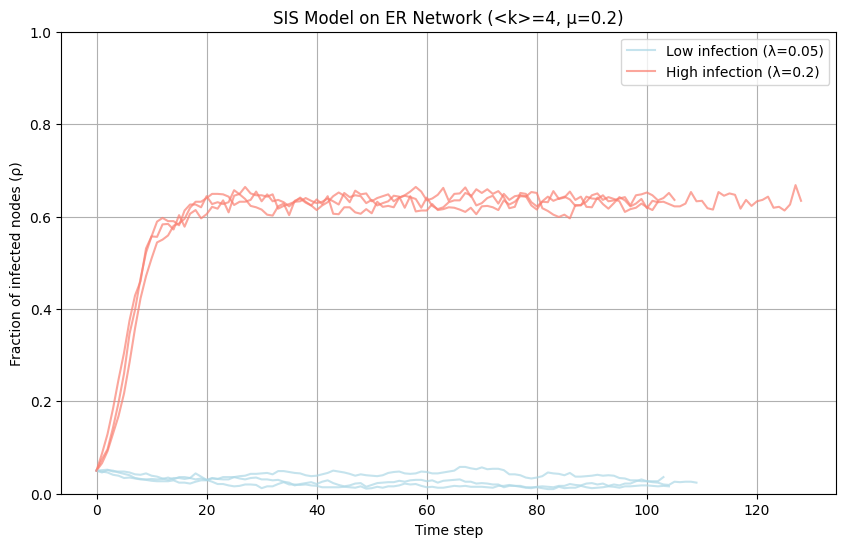

In [5]:
# Test parameters
nrealizations = 3  # Number of realizations per configuration
mu = 0.2  # Recovery probability
lambda_low = 0.05  # Low infection probability
lambda_high = 0.2  # Higher infection probability
initial_infected = 50
max_steps = 300

# Select one network for testing
test_network = networks['ER_4']

# Run simulations
results_low = []
results_high = []

for i in range(nrealizations):
    print(f"Running realization {i+1}/{nrealizations}")
    
    # Low lambda simulation
    _, infected_history_low = SIS_network_model(
        test_network, lambda_low, mu, initial_infected, max_steps
    )
    results_low.append(infected_history_low)
    
    # High lambda simulation
    _, infected_history_high = SIS_network_model(
        test_network, lambda_high, mu, initial_infected, max_steps
    )
    results_high.append(infected_history_high)

# Plot results
plt.figure(figsize=(10, 6))

for i in range(nrealizations):
    # Get data for this realization
    low_data = results_low[i]
    high_data = results_high[i]
    
    # Generate time steps
    t_low = np.arange(len(low_data))
    t_high = np.arange(len(high_data))
    
    # Plot with appropriate labels for the first realization only
    if i == 0:
        plt.plot(t_low, low_data, color='lightblue', alpha=0.7, 
                label=f'Low infection (λ={lambda_low})')
        plt.plot(t_high, high_data, color='salmon', alpha=0.7, 
                label=f'High infection (λ={lambda_high})')
    else:
        plt.plot(t_low, low_data, color='lightblue', alpha=0.7)
        plt.plot(t_high, high_data, color='salmon', alpha=0.7)

plt.xlabel('Time step')
plt.ylabel('Fraction of infected nodes (ρ)')
plt.title(f'SIS Model on ER Network (<k>=4, μ={mu})')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [13]:
# Create networks using the provided function
networks = create_networks(N=1000)

# Define the parameter ranges
lambda_values = np.arange(0, 0.31, 0.01)  # From 0 to 0.3 with step 0.01
mu_values = [0.2, 0.4]  # Recovery probabilities

# Dictionary to store results
results = {}

# Run simulations for each combination of parameters
print("Running simulations...")
start_time = time.time()

for mu in mu_values:
    results[mu] = {}
    for network_name, G in networks.items():
        results[mu][network_name] = []
        for lambda_val in lambda_values:
            print(f"Simulating: μ={mu}, network={network_name}, λ={lambda_val:.2f}")
            steady_state, _ = SIS_network_model(G, lambda_val, mu)
            results[mu][network_name].append(steady_state)
    
    # Create plot for current mu value
    plt.figure(figsize=(10, 6))
    for network_name in networks.keys():
        plt.plot(lambda_values, results[mu][network_name], marker='o', linestyle='-', label=network_name)
    
    plt.xlabel('Infection Probability (λ)')
    plt.ylabel('Steady State Infected Fraction (ρ)')
    plt.title(f'SIS Model: Steady State vs. Infection Probability (μ={mu})')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.savefig(f'sis_model_mu_{mu}.png')
    plt.close()

# Report execution time
end_time = time.time()
execution_time = end_time - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Create a combined plot with both μ values for comparison
plt.figure(figsize=(12, 8))
line_styles = ['-', '--']  # Different line styles for different μ values

for i, mu in enumerate(mu_values):
    for network_name in networks.keys():
        plt.plot(lambda_values, results[mu][network_name], 
                 marker='o', linestyle=line_styles[i], 
                 label=f"{network_name}, μ={mu}")

plt.xlabel('Infection Probability (λ)')
plt.ylabel('Steady State Infected Fraction (ρ)')
plt.title('SIS Model: Steady State vs. Infection Probability')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.savefig('sis_model_combined.png')
plt.close()

print("Simulations and plotting complete!")

ER_4 average degree: 4.00
ER_6 average degree: 5.97
BA_4 average degree: 3.99
BA_6 average degree: 5.98
Running simulations...
Simulating: μ=0.2, network=ER_4, λ=0.00
Converged after 101 steps
Simulating: μ=0.2, network=ER_4, λ=0.01
Converged after 101 steps
Simulating: μ=0.2, network=ER_4, λ=0.02
Converged after 101 steps
Simulating: μ=0.2, network=ER_4, λ=0.03
Converged after 101 steps
Simulating: μ=0.2, network=ER_4, λ=0.04
Converged after 104 steps
Simulating: μ=0.2, network=ER_4, λ=0.05
Converged after 111 steps
Simulating: μ=0.2, network=ER_4, λ=0.06
Converged after 129 steps
Simulating: μ=0.2, network=ER_4, λ=0.07
Converged after 143 steps
Simulating: μ=0.2, network=ER_4, λ=0.08
Converged after 108 steps
Simulating: μ=0.2, network=ER_4, λ=0.09
Converged after 139 steps
Simulating: μ=0.2, network=ER_4, λ=0.10
Converged after 180 steps
Simulating: μ=0.2, network=ER_4, λ=0.11
Converged after 143 steps
Simulating: μ=0.2, network=ER_4, λ=0.12
Converged after 112 steps
Simulating: μ=0

In [8]:

def run_multiple_realizations(G, lambda_val, mu, num_realizations=50, initial_infected=50, max_steps=300):
    """
    Run multiple realizations of the SIS model for the same parameter set
    
    Parameters:
    G (networkx.Graph): Network to run simulation on
    lambda_val (float): Infection probability per contact
    mu (float): Recovery probability
    num_realizations (int): Number of realizations to run
    initial_infected (int): Number of initially infected nodes
    max_steps (int): Maximum number of steps to run
    
    Returns:
    dict: Dictionary with mean, std_dev, and all individual results
    """
    results = []
    
    for i in range(num_realizations):
        print(f"Running realization {i+1}/{num_realizations} for λ={lambda_val:.2f}, μ={mu:.1f}")
        
        # Since the original SIS_network_model doesn't accept a seed parameter, 
        # we'll manually set the numpy random seed before calling it
        np.random.seed(i + int(lambda_val * 1000) + int(mu * 100))
        
        # Run the simulation with the original function (without seed parameter)
        steady_state, _ = SIS_network_model(
            G, lambda_val, mu, initial_infected, max_steps
        )
        
        results.append(steady_state)
    
    # Calculate statistics
    mean_result = np.mean(results)
    std_dev = np.std(results)
    
    return {
        'mean': mean_result,
        'std_dev': std_dev,
        'all_results': results
    }

# Main function to run all simulations
def run_all_simulations(num_realizations=50):
    # Create networks
    networks = create_networks(N=1000)
    
    # Define the parameter ranges
    lambda_values = np.arange(0, 0.31, 0.01)  # From 0 to 0.3 with step 0.01
    mu_values = [0.2, 0.4]  # Recovery probabilities
    
    # Dictionary to store results
    results = {}
    
    # Run simulations for each combination of parameters
    print("Running simulations...")
    start_time = time.time()
    
    for mu in mu_values:
        results[mu] = {}
        for network_name, G in networks.items():
            results[mu][network_name] = {
                'mean_values': [],
                'std_dev_values': [],
                'all_results': []
            }
            
            for lambda_val in lambda_values:
                print(f"Parameter set: μ={mu}, network={network_name}, λ={lambda_val:.2f}")
                
                # Run multiple realizations
                realization_results = run_multiple_realizations(
                    G, lambda_val, mu, num_realizations=num_realizations
                )
                
                # Store results
                results[mu][network_name]['mean_values'].append(realization_results['mean'])
                results[mu][network_name]['std_dev_values'].append(realization_results['std_dev'])
                results[mu][network_name]['all_results'].append(realization_results['all_results'])
                
                print(f"  Mean ρ = {realization_results['mean']:.4f}, StdDev = {realization_results['std_dev']:.4f}")
    
    # Report execution time
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"\nTotal execution time: {execution_time:.2f} seconds")
    
    # Export results to CSV
    export_results_to_csv(results, lambda_values, mu_values)
    
    # Create plots
    create_plots(results, lambda_values, mu_values)
    
    return results

# Function to create plots
def create_plots(results, lambda_values, mu_values):
    # Create separate plots for each mu value
    for mu in mu_values:
        plt.figure(figsize=(10, 6))
        
        for network_name in results[mu].keys():
            # Get data for this network
            mean_values = results[mu][network_name]['mean_values']
            std_dev_values = results[mu][network_name]['std_dev_values']
            
            # Plot with error bars
            plt.errorbar(
                lambda_values, 
                mean_values, 
                yerr=std_dev_values,
                marker='o', 
                linestyle='-', 
                label=network_name,
                capsize=3
            )
        
        plt.xlabel('Infection Probability (λ)')
        plt.ylabel('Steady State Infected Fraction (ρ)')
        plt.title(f'SIS Model: Steady State vs. Infection Probability (μ={mu})')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1)
        plt.savefig(f'sis_model_mu_{mu}_with_error_bars.png')
        plt.close()
    
    # Create a combined plot with both μ values for comparison
    plt.figure(figsize=(12, 8))
    line_styles = ['-', '--']  # Different line styles for different μ values
    
    for i, mu in enumerate(mu_values):
        for network_name in results[mu].keys():
            mean_values = results[mu][network_name]['mean_values']
            std_dev_values = results[mu][network_name]['std_dev_values']
            
            plt.errorbar(
                lambda_values, 
                mean_values, 
                yerr=std_dev_values,
                marker='o', 
                linestyle=line_styles[i], 
                label=f"{network_name}, μ={mu}",
                capsize=3
            )
    
    plt.xlabel('Infection Probability (λ)')
    plt.ylabel('Steady State Infected Fraction (ρ)')
    plt.title('SIS Model: Steady State vs. Infection Probability')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.savefig('sis_model_combined_with_error_bars.png')
    plt.close()
    
    print("Plots with error bars created successfully!")

# Function to export results to CSV files
def export_results_to_csv(results, lambda_values, mu_values):
    """
    Export simulation results to CSV files for future use
    
    Parameters:
    results (dict): Dictionary containing the simulation results
    lambda_values (array): Array of lambda values used in simulations
    mu_values (list): List of mu values used in simulations
    """
    import csv
    import os
    
    # Create a directory for CSV files if it doesn't exist
    csv_dir = "results_csv"
    if not os.path.exists(csv_dir):
        os.makedirs(csv_dir)
    
    # Export summary results (means and standard deviations)
    for mu in mu_values:
        # Create separate CSV for each mu value
        with open(os.path.join(csv_dir, f'summary_results_mu_{mu}.csv'), 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            
            # Write header
            header = ['lambda']
            for network_name in results[mu].keys():
                header.extend([f'{network_name}_mean', f'{network_name}_std_dev'])
            writer.writerow(header)
            
            # Write data
            for i, lambda_val in enumerate(lambda_values):
                row = [lambda_val]
                for network_name in results[mu].keys():
                    row.append(results[mu][network_name]['mean_values'][i])
                    row.append(results[mu][network_name]['std_dev_values'][i])
                writer.writerow(row)
    
    # Export detailed results (all individual realizations)
    for mu in mu_values:
        for network_name in results[mu].keys():
            with open(os.path.join(csv_dir, f'detailed_results_mu_{mu}_{network_name}.csv'), 'w', newline='') as csvfile:
                writer = csv.writer(csvfile)
                
                # Write header - lambda followed by realization numbers
                num_realizations = len(results[mu][network_name]['all_results'][0])
                header = ['lambda'] + [f'realization_{i+1}' for i in range(num_realizations)]
                writer.writerow(header)
                
                # Write data - each row contains lambda and all realization results
                for i, lambda_val in enumerate(lambda_values):
                    row = [lambda_val] + results[mu][network_name]['all_results'][i]
                    writer.writerow(row)
    
    # Export combined results for easy plotting and comparison
    with open(os.path.join(csv_dir, 'combined_results.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write header
        header = ['lambda']
        for mu in mu_values:
            for network_name in results[mu].keys():
                header.extend([f'{network_name}_mu_{mu}_mean', f'{network_name}_mu_{mu}_std_dev'])
        writer.writerow(header)
        
        # Write data
        for i, lambda_val in enumerate(lambda_values):
            row = [lambda_val]
            for mu in mu_values:
                for network_name in results[mu].keys():
                    row.append(results[mu][network_name]['mean_values'][i])
                    row.append(results[mu][network_name]['std_dev_values'][i])
            writer.writerow(row)
    
    print(f"Results exported to CSV files in the '{csv_dir}' directory")


In [10]:
 results = run_all_simulations(num_realizations=50)

ER_4 average degree: 4.02
ER_6 average degree: 5.76
BA_4 average degree: 3.99
BA_6 average degree: 5.98
Running simulations...
Parameter set: μ=0.2, network=ER_4, λ=0.00
Running realization 1/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 2/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 3/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 4/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 5/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 6/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 7/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 8/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 9/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 10/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 11/50 for λ=0.00, μ=0.2
Converged after 101 steps
Running realization 12/50 for λ=0.00, μ=0.2
Converged after 101 steps